# Load the libraries & data

In [2]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import scipy
import os
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
from ipywidgets import interact
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import TransformerMixin, ClassifierMixin
from sklearn.utils import resample as sk_resample
from datasets import load_dataset
import statsmodels.api as sm
import jax
import pickle
import jax.numpy as jnp
import multiprocessing
from unicodedata import normalize as normalize_unicode


In [3]:

try:
    with open("dataset.pickle", "rb") as f:
        print("Loading from disk")
        dataset = pickle.load(f)
        print("Done from disk")
except FileNotFoundError:
    dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Handmade_Products", trust_remote_code=True)
    with open("dataset.pickle", "wb") as f:
        pickle.dump(dataset, f)

data = pd.DataFrame(dataset["full"])[["text", "rating"]]
data["text"] = data["text"].apply(lambda s: normalize_unicode("NFKD", s))
train_x, test_x, train_y, test_y = train_test_split(data["text"], data["rating"], test_size=0.2)
num_classes = np.unique(train_y).size
num_train_obs = train_x.shape[0]
train_x

Loading from disk
Done from disk


340462                                              Love it
233053    I received my first God Pod as a gift. I loved...
503293                                          It's lovely
224009    This apron is super cute and you can tell that...
294633    I recommend the cover to everyone. Please make...
                                ...                        
539228                                        Cheaply made.
605935    I am very happy with this wreath.<br />It matc...
127527    I like the neck lk ace but the stamp with my i...
192600    I love these! They are good quality and exactl...
206635                      super cute and easy to install.
Name: text, Length: 531329, dtype: object

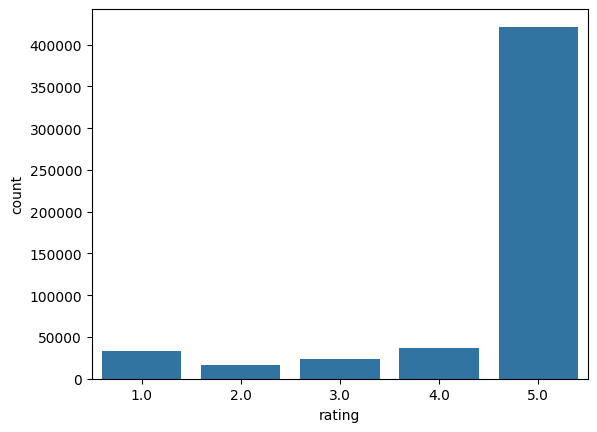

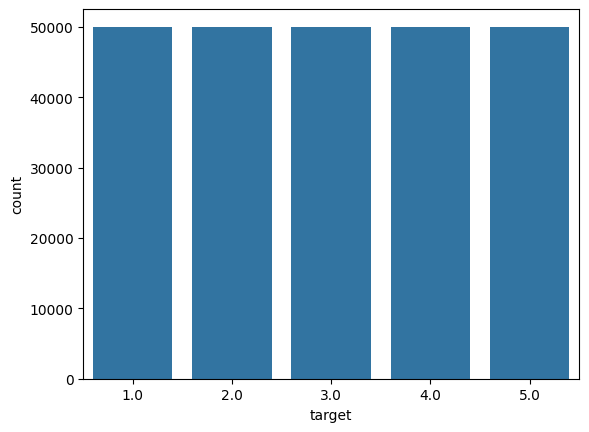

In [4]:
def visualize_class_imbalance(y):
    ch = sns.barplot(y.value_counts())
    return ch

def resample(x, y, target_samples):
    df = pd.concat([x, y], axis=1)
    df.columns = ['feature', 'target']


    resampled_dfs = []
    for category in df['target'].unique():
        category_df = df[df['target'] == category]
        n_samples = len(category_df)
        if n_samples < target_samples:
            # Upsample the minority class
            n_to_upsample = target_samples - n_samples
            upsampled = sk_resample(category_df,
                                     replace=True,
                                     n_samples=target_samples,
                                     random_state=42)
            resampled_dfs.append(upsampled)
        else:
            # If the class already has the maximum number of samples, keep it as is
            resampled_dfs.append(category_df.sample(target_samples))

    df_resampled = pd.concat(resampled_dfs)
    x_resampled = df_resampled['feature']
    y_resampled = df_resampled['target']
    return x_resampled, y_resampled
    
visualize_class_imbalance(train_y)
plt.show()
train_x_resampled, train_y_resampled = resample(train_x, train_y, 50000)
visualize_class_imbalance(train_y_resampled)
plt.show()

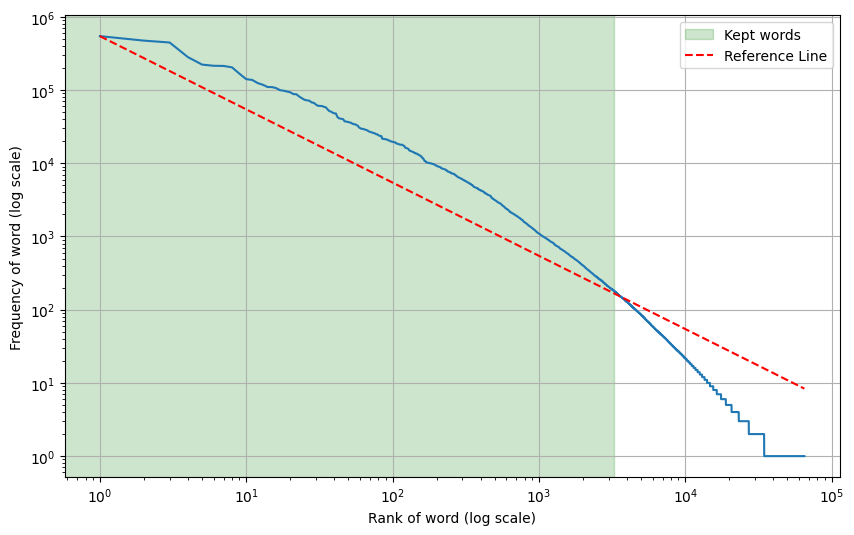

In [5]:
# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the training data
X_train_counts = vectorizer.fit_transform(train_x)

# Sum word counts across all documents
word_counts = np.asarray(X_train_counts.sum(axis=0)).flatten()

# Sort word counts in descending order
sorted_word_counts = np.sort(word_counts)[::-1]

# Create ranks (1, 2, 3, ...)
ranks = np.arange(1, len(sorted_word_counts) + 1)



# Create the log-log plot
plt.figure(figsize=(10, 6))
plt.loglog(ranks, sorted_word_counts)
plt.xlabel("Rank of word (log scale)")
plt.ylabel("Frequency of word (log scale)")
plt.grid(True)


# Calculate a reference line based on Zipf's law (frequency ~ C/rank)
# We can set C = frequency of the most frequent word
zipf_line = sorted_word_counts[0] / ranks

plt.axvspan(0, len(ranks) * 0.05, ymin=0, ymax=1, color='green', alpha=0.2, label='Kept words')


# Plot the reference line
plt.loglog(ranks, zipf_line, label="Reference Line", linestyle='--', color='red')
plt.legend()
plt.savefig("figures/zipf_law.png")
plt.show()

In [6]:
word_counts = pd.DataFrame({"words": vectorizer.get_feature_names_out(), "counts": word_counts}) \
.sort_values("counts", ascending=False) \

quantiles = np.linspace(0, 1, 101)
indexes = quantiles * (len(word_counts) - 1)

word_percentiles = word_counts.iloc[indexes.astype(int), :].copy()
word_percentiles["percentile"] = (quantiles[::-1] * 100).astype(int)

word_percentiles = word_percentiles.rename(columns={"words": "word", "counts": "count"})

word_percentiles[:50].to_csv("figures/word_percentiles_top.csv", index=False)
word_percentiles[50:].to_csv("figures/word_percentiles_bottom.csv", index=False)
word_percentiles

,word,count,percentile
58195,the,545042,100
51932,seem,2096,99
64020,wonderfully,755,98
51789,sealed,415,97
9880,blocks,258,96
...,...,...,...
897,1x2,1,4
653,1912,1,3
63942,wl,1,2
64548,xayah,1,1


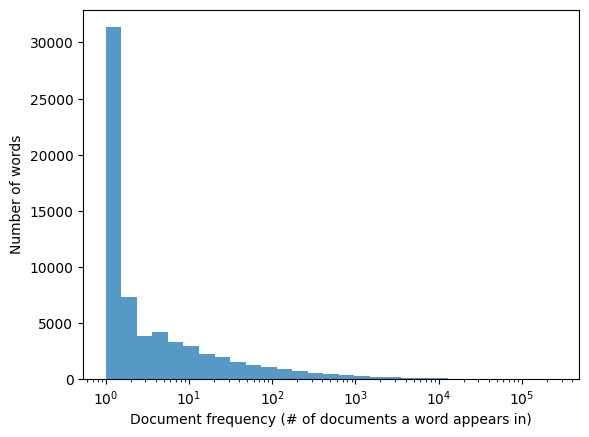

In [7]:

document_frequencies = np.asarray((X_train_counts > 0).sum(axis=0)).reshape((-1,))
axs = plt.axes()
ax = sns.histplot(document_frequencies, bins=np.logspace(np.log10(document_frequencies.min()), np.log10(document_frequencies.max()), 30))
ax.set_xscale("log")
ax.set_xlabel("Document frequency (# of documents a word appears in)")
ax.set_ylabel("Number of words")



plt.savefig("figures/document_frequency_histogram.png")

# Model

## Training

In [ ]:

class RemovePercentileWordsTransformer(TransformerMixin):
    def __init__(self, min_percentile, max_percentile):
        self.min_percentile = min_percentile
        self.max_percentile = max_percentile
        pass

    def fit(self, X, y=None, **fit_params):
        frequencies = np.asarray((X > 0).sum(axis=0)).reshape((-1,))
        
        max_occurances = int(np.percentile(frequencies, self.max_percentile*100.0))
        min_occurances = int(np.percentile(frequencies, self.min_percentile*100.0))
        #axs = plt.axes()
        # axs.axvspan(min_occurances, max_occurances, ymin=0, ymax=1, color='green', alpha=0.2, label='Kept words')
        
        # ax = sns.histplot(frequencies, bins=np.logspace(np.log10(frequencies.min()), np.log10(frequencies.max()), 30))
        # ax.set_xscale("log")
        # ax.set_xlabel("Document frequency (# of documents the word appears in)")
        # ax.set_ylabel("Number of words")

        # plt.text(min_occurances, 10000, f"{min_occurances} ({self.min_percentile})", rotation=90, ha='center', va='center', color='green')
        # plt.text(max_occurances, 10000, f"{max_occurances} ({self.max_percentile})", rotation=90, ha='center', va='center', color='green')
        
        # plt.legend()
        # plt.savefig("figures/percentile_words.png")
        # plt.show()

        # print(f"Keeping words with {min_occurances} ({self.min_percentile} quantile) < frequency < {max_occurances} ({self.max_percentile} quantile)", )
        
        self.keep_columns = np.logical_and(frequencies >= min_occurances, frequencies <= max_occurances)
        
        print(f"i.e. keeping {self.keep_columns.sum() / X.shape[1]} = {self.keep_columns.sum()} feature dimensions")
        return self

    def transform(self, X, y=None, **fit_params):
        cut_X = X[:, self.keep_columns]
        return cut_X
    
class StatsModelsLR(ClassifierMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        self.model = sm.MNLogit(y, X)
        self.res = self.model.fit(method="lbfgs", maxiter=2000)
        return self

    def predict(self, X):
        return self.model.predict(X)

pipeline = Pipeline([
    ("tf", CountVectorizer()),
    ("remove_percentile_words", RemovePercentileWordsTransformer(0.95, 1.0)), # we should tweak this
    # ("classification", LogisticRegression(max_iter=2000, class_weight="balanced")) # , class_weight="balanced"
])

X = pipeline.fit(train_x, train_y)

coeffs = []
intercepts = []

for i in range(10):
    sample_indices = sk_resample(np.arange(X.shape[0]), replace=True)

    resampled_x = X[sample_indices]
    resampled_y = train_y.iloc[sample_indices]
    
    lr = LogisticRegression(max_iter=2000, class_weight="balanced")
    lr.fit(X, resampled_y)
    coeffs.append(lr.coef_)
    intercepts.append(lr.intercept_)
    print(f"Done one round")

KeyboardInterrupt: 

In [9]:
test_pred_y = pipeline.predict(test_x)
train_pred_y = pipeline.predict(train_x)

,one,two,three,four,five,macroavg,weightedavg
precision,0.545,0.292,0.322,0.246,0.972,0.475,0.845
recall,0.716,0.409,0.432,0.500,0.827,0.577,0.767
f1-score,0.619,0.340,0.369,0.329,0.894,0.510,0.797
support,33323.000,16461.000,23979.000,36179.000,421387.000,531329.000,531329.000
within-1,0.879,0.915,0.816,0.905,0.943,0.891,0.929


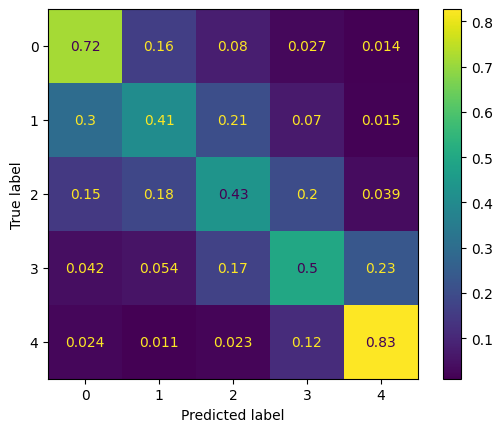

In [10]:
def advanced_stats(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, normalize="true")

    ConfusionMatrixDisplay(cm).plot()
    report = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).drop(columns=["accuracy"])


    within_1_prop = np.array([
        (np.abs(y_true[y_true == i] - y_pred[y_true == i]) <= 1.001).mean() for i in range(1, num_classes+1)
    ])

    within_1_prop_tot = (np.abs(y_true - y_pred) <= 1.001).mean() 

    report.loc['within-1'] = np.array([*within_1_prop, within_1_prop.mean(), within_1_prop_tot])
    return report.rename(columns={"1.0": "one", "2.0": "two", "3.0": "three", "4.0": "four", "5.0": "five", "macro avg": "macroavg", "weighted avg": "weightedavg"}).round(3)

s = advanced_stats(train_y, train_pred_y)
plt.savefig("figures/confusion_matrix_train.png")
s.to_csv("figures/evaluation_train.csv", index_label="Quantity")
s

In [1]:
s = advanced_stats(test_y, test_pred_y)
plt.savefig("figures/confusion_matrix_test.png")
s.to_csv("figures/evaluation_test.csv", index_label="Quantity")
s

NameError: name 'advanced_stats' is not defined

## Parameter analysis

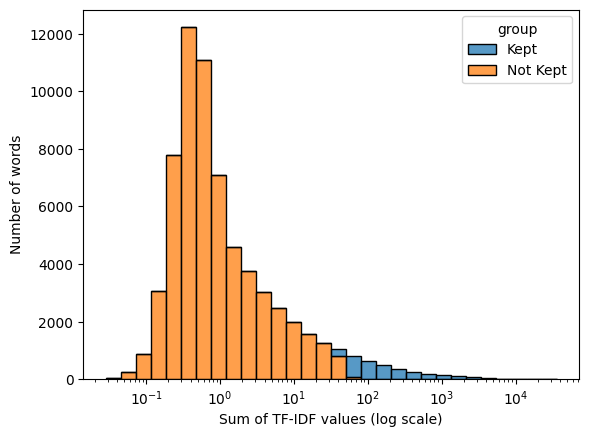

In [26]:
tfidf = TfidfVectorizer()
tfidf.fit(train_x)

tfidf_sums = pd.DataFrame({
    "words": tfidf.get_feature_names_out().reshape(-1),
    "values": tfidf.transform(train_x).sum(axis=0).A1
})
sums_kept = tfidf_sums[pipeline.named_steps["remove_percentile_words"].keep_columns].copy()
sums_not_kept = tfidf_sums[~pipeline.named_steps["remove_percentile_words"].keep_columns].copy()

# Add group labels
sums_kept['group'] = 'Kept'
sums_not_kept['group'] = 'Not Kept'

sns.histplot(data=pd.concat([sums_kept, sums_not_kept]), x="values", hue="group", multiple="stack", bins=30, log_scale=True)
plt.xlabel("Sum of TF-IDF values (log scale)")
plt.ylabel("Number of words")
plt.show()

In [14]:
lr: LogisticRegression = pipeline.named_steps["classification"]
tf: CountVectorizer = pipeline.named_steps["tf"]
remove_percentile_words: RemovePercentileWordsTransformer = pipeline.named_steps["remove_percentile_words"]

betas = np.hstack((lr.intercept_.reshape((-1, 1)), lr.coef_)) # (n_classes, p+1)

tf_matrix = remove_percentile_words.transform(tf.transform(train_x))
X_design = scipy.sparse.hstack([csr_matrix(np.ones((tf_matrix.shape[0], 1))), tf_matrix], format='csr')

In [15]:
scores = X_design @ betas.T
exp_scores = np.exp(scores)
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

In [11]:
def get_word_scores(pipeline: Pipeline):
    tf: CountVectorizer = pipeline.named_steps["tf"]
    lr: LogisticRegression = pipeline.named_steps["classification"]
    remove_percentile_words: RemovePercentileWordsTransformer = pipeline.named_steps["remove_percentile_words"]
    words = tf.get_feature_names_out()[remove_percentile_words.keep_columns]
    
    coefficients = []
    for idx, cl in enumerate(lr.classes_):
        # Create a row for each word with its coefficient for this class
        for word_idx, (word, coef) in enumerate(zip(words, lr.coef_[idx])):
            coefficients.append({
                "class": cl,
                "word": word,
                "coef": coef
            })
    
    return pd.DataFrame(coefficients).sort_values("coef", key=lambda k: abs(k), ascending=False)

scores = get_word_scores(pipeline)
scores.groupby("class").head(5).set_index("class").sort_index()

,word,coef
class,,
1.0,complements,-2.634274
1.0,excelente,-2.336780
1.0,happier,-2.163406
1.0,spectacular,-2.216427
1.0,unhappy,2.088693
2.0,incredible,-2.250213
2.0,holders,-2.104641
2.0,served,-2.094545
2.0,presents,-2.071817


In [ ]:
scores[scores["coef"] == ]

# Word correlations

In [3]:
def word_covariances(tf_mat: np.ndarray):
    n, d = tf_mat.shape
    mean_freq = tf_mat.mean(axis=0).A1
    XtX = tf_mat.T @ tf_mat
    mean_outer = jnp.outer(mean_freq, mean_freq) * n

    # Using Cov(X) = (X'X - x_bar x_bar' * n)/(n-1)
    cov_uncorrected = jnp.subtract(XtX.toarray(), mean_outer).astype("float32")
    cov = jnp.divide(cov_uncorrected, n-1)
    return cov

try:
    word_cov
except NameError:
    try:
        with open("word_cov.pickle", "rb") as f:
            print("Loading from disk")
            word_cov = pickle.load(f)
        print("Loaded from disk")
    except FileNotFoundError:
        print("Calculating")
        word_cov = word_covariances(pipeline.named_steps["tf"].transform(train_x_resampled))
        with open("word_cov.pickle", "wb") as f:
            pickle.dump(word_cov, f)
        print("Calculated")

word_var = jnp.diag(word_cov)

inv_std_dev = (word_var ** -0.5).astype("float32")
# Calculate correlation matrix using broadcasting to avoid large diagonal matrices
word_cor = inv_std_dev[:, None] * word_cov * inv_std_dev[None, :]

Loading from disk
Loaded from disk


2025-04-30 10:31:10.520393: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.94GiB (rounded to 5302461184)requested by op 
2025-04-30 10:31:10.520439: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] *_*************************************************************************************************x
E0430 10:31:10.520450 2192362 pjrt_stream_executor_client.cc:2839] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 5302461124 bytes. [tf-allocator-allocation-error='']


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 5302461124 bytes.

In [5]:
word_cor[1, 5]

Array(-0., dtype=float16)

In [33]:
tf: CountVectorizer = pipeline.named_steps["tf"]
# Create inverse vocabulary mapping (index -> word)
inv_vocabulary = {v: k for k, v in tf.vocabulary_.items()}

# Get the indices from word_pairs
idx1 = word_pairs[0]
idx2 = word_pairs[1]

# Find the corresponding words
print("Top 10 word pairs by covariance:")
for i in range(len(idx1)):
    word1 = inv_vocabulary.get(int(idx1[i]), "N/A")
    word2 = inv_vocabulary.get(int(idx2[i]), "N/A")
    print(f"({word1}, {word2}) - Covariance: {values[i]:.4f}")



Top 10 word pairs by covariance:
(11x14, sending) - Covariance: 1.0000
(12, according) - Covariance: 1.0000
(12, decorating) - Covariance: 1.0000
(12, ribbon) - Covariance: 1.0000
(123, 4mm) - Covariance: 1.0000
(123, pounds) - Covariance: 1.0000
(123, studs) - Covariance: 1.0000
(13, 21) - Covariance: 1.0000
(13, attest) - Covariance: 1.0000
(13, caught) - Covariance: 1.0000
(13, cord) - Covariance: 1.0000
(13, db1f7f51a1c731870846e43261d55445) - Covariance: 1.0000
(13, depending) - Covariance: 1.0000
(13, elasticized) - Covariance: 1.0000
(13, fate) - Covariance: 1.0000
(13, gotta) - Covariance: 1.0000
(13, heavier) - Covariance: 1.0000
(13, lab) - Covariance: 1.0000
(13, labradorite) - Covariance: 1.0000
(13, rare) - Covariance: 1.0000
(13, ruin) - Covariance: 1.0000
(13, stretchy) - Covariance: 1.0000
(13, tempt) - Covariance: 1.0000
(13, tones) - Covariance: 1.0000
(13, tugged) - Covariance: 1.0000
(13, viewing) - Covariance: 1.0000
(13, visible) - Covariance: 1.0000
(16x20, dream

In [ ]:
def get_parameter_intervals(model: LinearRegression):
    model.coef_ # (n, d)

#np.nanmin(word_cov)
word_cov.shape
jnp.nanmin(word_cov)
jnp.nanmax(word_cov)


In [14]:
import pickle
with open("word_cov.pickle", "wb") as f:
    pickle.dump(np.array(word_cov), f)

In [ ]:

jnp.nanmin(word_cov)

Loading from disk
Loaded from disk


KeyboardInterrupt: 

In [19]:
cv = CountVectorizer()
word_counts = cv.fit_transform(train_x).sum(axis=0).reshape((-1, ))

In [20]:
percentile_words = np.array(np.argsort(word_counts)[:, np.linspace(word_counts.shape[1]/2, word_counts.shape[1]-1, 49).astype("int")]).reshape((-1, ))
print()
voc_inv = dict(zip(cv.vocabulary_.values(), cv.vocabulary_.keys()))
percentiles = np.linspace(51, 100, 49)
words = []
counts = []
for p in percentile_words:
    words.append(voc_inv[int(p)])
    counts.append(word_counts[0, p])
    
print(words)
word_percentiles = pd.DataFrame({'percentile': percentiles, 'word': words, "count": counts})
word_percentiles["percentile"] = np.round(word_percentiles["percentile"])
word_percentiles.to_csv("word_percentiles.csv", index=False)


['brink', 'pocketable', 'marlinspike', 'soundbar', 'silpada', 'topmost', 'atones', 'fanstastic', 'asg', '2month', 'sevice', 'wasp', 'dpt', 'costal', 'drs', 'angus', 'julius', 'knotty', 'lingered', 'mjlulu', 'matcha', 'ami', 'pleasurable', 'serotonin', 'salute', 'noone', 'cloak', 'mot', 'aparte', 'paranoid', '09', 'groovy', 'component', 'unsurpassed', 'jute', 'deter', 'tender', 'lounge', 'motto', 'grabbing', 'essence', 'continues', 'grandfather', 'serious', 'situation', 'garbage', 'pearls', 'arrive', 'the']


TimeoutError: [Errno 60] Operation timed out: 'word_percentiles.csv'

In [ ]:
def get_classification_report(pred_y, test_y):
    report = pd.DataFrame(classification_report(pred_y, test_y, output_dict=True))

    # Remove the accuracy column from the report since that formats badly
    return report.drop(columns=["accuracy"])

get_classification_report(pred_y, test_y)

,1.0,2.0,3.0,4.0,5.0,macro avg,weighted avg
precision,0.696322,0.253504,0.313518,0.411309,0.799249,0.494781,0.686977
recall,0.380488,0.189316,0.243194,0.218198,0.963315,0.398902,0.727696
f1-score,0.492087,0.216758,0.273914,0.285133,0.873646,0.428308,0.692799
support,15078.000000,5541.000000,7677.000000,17035.000000,87502.000000,132833.000000,132833.000000
